# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data

In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from IPython.display import clear_output
%matplotlib inline

In [2]:
torch.manual_seed(7)
np.random.seed(7)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset(dimx=48, dimy=48)


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [5]:
len(data), len(attrs)

(13143, 13143)

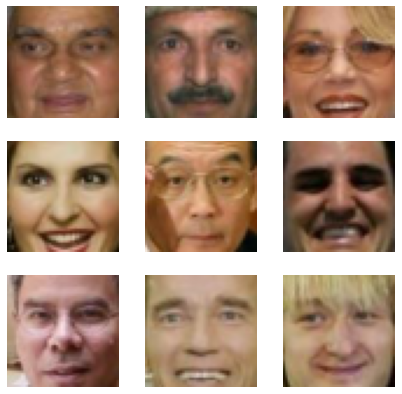

In [6]:
# Выведем рандомные 9 картинок

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(7, 7), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_face_idx = int(np.random.uniform(0, len(data)))
    face_image = data[random_face_idx]
    fig_x.axis('off')
    fig_x.imshow(face_image)

#plt.show()

In [7]:
attrs.loc[:, 'Smiling'] = attrs['Smiling'].apply(pd.to_numeric)

In [8]:
train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs, test_size=0.2)

train_attrs.reset_index(drop=True, inplace=True)
val_attrs.reset_index(drop=True, inplace=True)

In [9]:
data_transforms = transforms.Compose([
        #transforms.Resize(rescale_size) # but here all images are the same size, so don't use Resize()
        transforms.ToTensor()
        #transforms.Normalize(train_data_mean, train_data_std)
    ])

def image2tensor(img_data):
    # img_data -- numpy.ndarray, its shape: HxWxC
    # but we use transforms.ToTensor() which is able to work with HxWxC properly (see documentation)
    img_data_tensor = data_transforms(img_data)
    return img_data_tensor


def tensor2image(img_data_tensor):
    image = img_data_tensor.detach().cpu()
    image = image.numpy() # (CxHxW)
    image = np.moveaxis(image, 0, 2) # (HxWxC)
    return image

### Create DataLoader objects for train and valid data

In [10]:
class LFW_Dataset(Dataset):
    def __init__(self, images):
        super().__init__()
        self.images = images
        self.attrs = attrs
        self.len_ = len(self.images)
    
    def __len__(self):
        return self.len_
    
    def __getitem__(self, index):
        image = self.images[index]
        image_tensor = image2tensor(image)
        image_tensor = image_tensor.to(torch.float32) # numpy dtype==float64 => here tensors' type will be torch.float64
        # but in conv2d needs torch.float32
        return image_tensor
    
    def get_batch_tensors_by_indexes(self, indexes):
        images = [self[index] for index in indexes]
        return torch.stack(images, dim=0)

In [11]:
BATCH_SIZE = 128

train_dataset = LFW_Dataset(train_data)
trainloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 4)

valid_dataset = LFW_Dataset(val_data)
validloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 4)

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

In [12]:
# картинки размера 45x45 (+3 канаа) => 6075 чисел описывают каждую картину,
dim_code = 512 # выберите размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [13]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        """
        <определите архитектуры encoder и decoder>
        """
        super().__init__()
        
        # Choose convolutional architecture.
        
        # 1. Encoder
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.enc_pool0 = nn.MaxPool2d(kernel_size=2, stride=2) # 48 -> 24
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 24 -> 12
        
        self.enc_fc0 = nn.Linear(64*12*12, dim_code)
        
        # 2. Decoder
        self.dec_fc0 = nn.Linear(dim_code, 64*12*12)
        
        self.dec_upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2) # 12 -> 24
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.dec_upsample1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2) # 24 -> 48
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),
            #nn.BatchNorm2d(3),
            nn.Sigmoid())

    def decoder_forward(self, latent_code):
        x = self.dec_fc0(latent_code)
        x = x.view(-1, 64, 12, 12)
        x = self.dec_conv0(self.dec_upsample0(x))
        reconstruction = self.dec_conv1(self.dec_upsample1(x))
        return reconstruction

    def forward(self, x):
        """
        <реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code)
        и полученная реконструкция изображения (reconstruction)>
        """
        # 1. Encoder
        x = self.enc_pool0(self.enc_conv0(x))
        x = self.enc_pool1(self.enc_conv1(x))
        x = torch.flatten(x, 1)
        
        # 2. Latent code
        latent_code = self.enc_fc0(x)
        
        # 3. Decoder
        reconstruction = self.decoder_forward(latent_code)
        
        return reconstruction, latent_code

In [14]:
criterion = nn.BCELoss()
# reduction='sum' -- https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

autoencoder = Autoencoder().to(device)

NUM_EPOCHS = 30
lr = 5e-3
weight_decay=0.01
optimizer = optim.AdamW(autoencoder.parameters(), lr=lr, weight_decay=weight_decay)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
num_warmup_steps=int(len(train_dataset)/BATCH_SIZE*7)
scheduler = get_cosine_schedule_with_warmup(optimizer,
        num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

print(num_warmup_steps, num_train_steps)

574 2464


Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [15]:
def train_fn(net, loader, criterion, optimizer, scheduler=None):
    running_loss = 0
    processed_data = 0
    
    pbar = tqdm(total = len(loader), desc='Training')
    for _, (in_images) in enumerate(loader):
        in_images = in_images.to(device)
        net.train()
        optimizer.zero_grad()
        outputs, latent_code = net(in_images)
        loss = criterion(outputs, in_images)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        running_loss += loss.item() * in_images.shape[0]
        processed_data += in_images.size(0)
        
        pbar.update()
    
    pbar.close()
    train_loss = running_loss / processed_data
    return train_loss


def valid_fn(net, loader, criterion):
    
    running_loss = 0
    processed_data = 0
    
    pbar = tqdm(total = len(loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for _, (in_images) in enumerate(loader):
            
            in_images = in_images.to(device)
            net.eval()
            outputs, latent_code = net(in_images)
            loss = criterion(outputs, in_images)
            
            running_loss += loss.item()*in_images.shape[0]
            processed_data += in_images.size(0)
            
            pbar.update()
    
    pbar.close()
    val_loss = running_loss / processed_data
    return val_loss

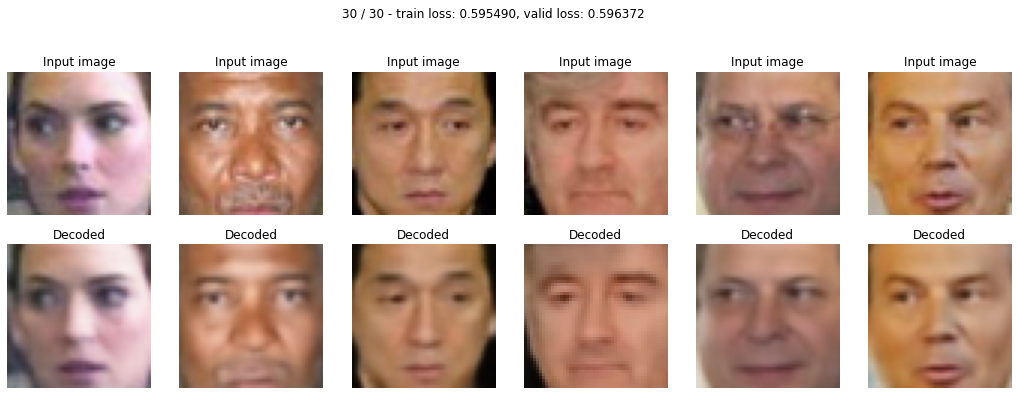

In [16]:
train_loss = []
valid_loss = []

X_val = next(iter(validloader)) # for visualizing
X_val = X_val.to(device)

for epoch in range(NUM_EPOCHS):
    
    tl = train_fn(autoencoder, trainloader, criterion, optimizer, scheduler)
    vl = valid_fn(autoencoder, validloader, criterion)
    train_loss.append(tl)
    valid_loss.append(vl)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl)
    tqdm.write(printstr)
    
    # Visualize tools
    autoencoder.eval()
    with torch.no_grad():
        Y_hat, _ = autoencoder(X_val)
        Y_hat = Y_hat.detach().cpu()

    clear_output(wait=True)
    plt.figure(figsize=(18,9))
    for k in range(6):
        plt.subplot(3, 6, k+1)
        plt.imshow(tensor2image(X_val[k]))
        plt.title('Input image')
        plt.axis('off')

        plt.subplot(3, 6, k+7)
        plt.imshow(tensor2image(Y_hat[k]))
        plt.title('Decoded')
        plt.axis('off')
    plt.suptitle('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, NUM_EPOCHS, tl, vl))
    plt.show()

/home/neurus/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/neurus/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


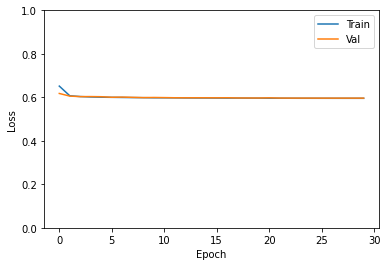

In [17]:
plt.figure()
plt.ylim(0, 1.0)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

### Generate "fine" random vectors (latent codes)

In [18]:
train_data_latent_codes = []

with torch.no_grad():
    for _, (in_images) in enumerate(trainloader):
        in_images = in_images.to(device)
        autoencoder.eval()
        _, latent_code = autoencoder(in_images)
        latent_code = latent_code.detach().cpu().numpy()
        train_data_latent_codes.append(latent_code)

In [19]:
train_data_latent_codes = np.vstack(train_data_latent_codes)

In [20]:
train_data_latent_codes

array([[ 14.626583  , -10.411928  ,  -1.653177  , ...,  -1.5637889 ,
         -2.713824  ,  -4.59301   ],
       [ -5.2704177 ,   0.583325  ,  -3.8367627 , ...,  -1.6417311 ,
          0.9824226 ,  -1.2108029 ],
       [  2.0554044 ,   6.747746  ,   8.772156  , ...,   0.3319725 ,
          1.8208067 ,  16.189947  ],
       ...,
       [ -5.657257  ,   4.6485763 ,   0.36582822, ...,  -2.4649093 ,
         -7.0806723 ,   0.1110427 ],
       [ -5.857952  ,   2.9338925 ,  -3.5526907 , ...,  -0.9054992 ,
         -1.1733962 ,   5.6717205 ],
       [ 14.711866  ,  -1.1648682 ,  -2.2859771 , ...,  -0.20702556,
         -1.6727912 ,  -5.68779   ]], dtype=float32)

In [21]:
train_data_latent_codes.shape

(10514, 512)

In [22]:
mean = train_data_latent_codes.mean(axis=0)
std = train_data_latent_codes.std(axis=0)

In [23]:
z = np.random.normal(loc=mean, scale=std, size=(25,512))

autoencoder.eval()
with torch.no_grad():
    z = torch.tensor(z).to(device, torch.float32)
    output = autoencoder.decoder_forward(z)
    output = output.detach().cpu()

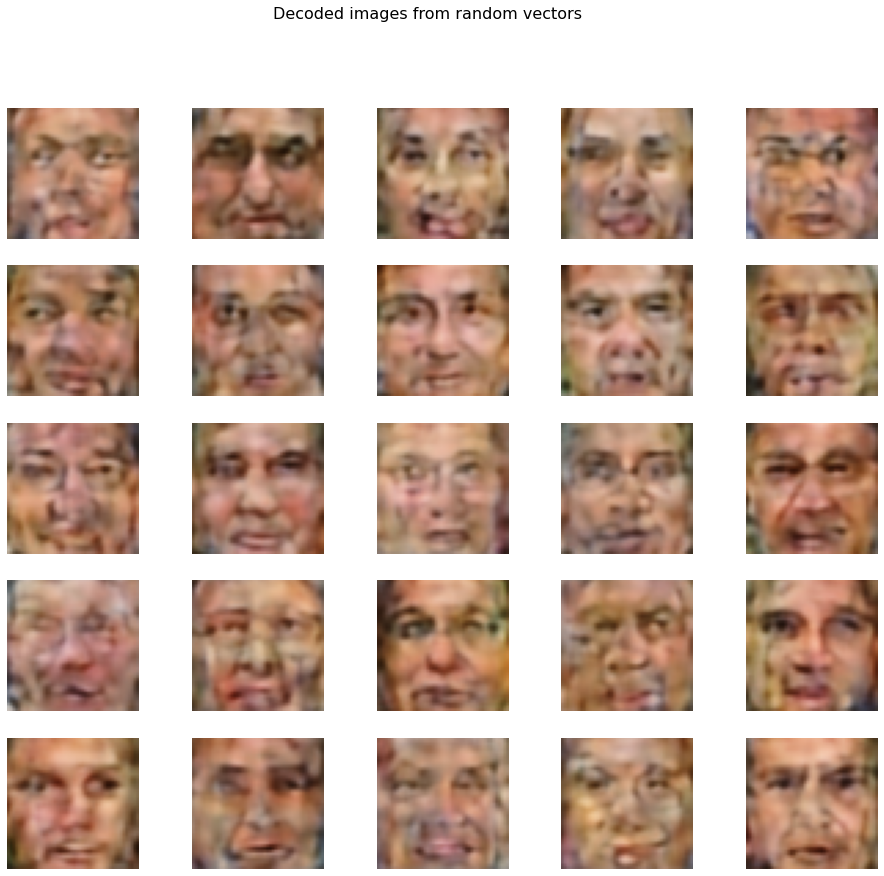

In [24]:
# отрисуем вывод декодера по этим векторам
fig = plt.figure(figsize=(16,14))
fig.suptitle('Decoded images from random vectors', fontsize=16)

for image_idx in range(len(output)):
    ax = fig.add_subplot(5, 5, image_idx+1)
    ax.imshow(tensor2image(output[image_idx]))
    ax.axis('off')

plt.show()

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [25]:
COUNT = 25
train_smiling_indexes = train_attrs.nlargest(COUNT, 'Smiling').index
train_sad_indexes = train_attrs.nsmallest(COUNT, 'Smiling').index

In [26]:
autoencoder.eval()
with torch.no_grad():
    # 1. Mean latent vector of smiling people
    z = train_dataset.get_batch_tensors_by_indexes(train_smiling_indexes)
    z = z.to(device, torch.float32)
    _, smiling_latent_vectors = autoencoder.forward(z)
    smiling_mean_latent_vector = smiling_latent_vectors.mean(dim=0)
    
    # 2. Mean latent vector of sad people
    z = train_dataset.get_batch_tensors_by_indexes(train_sad_indexes)
    z = z.to(device, torch.float32)
    _, sad_latent_vectors = autoencoder.forward(z)
    sad_mean_latent_vector = sad_latent_vectors.mean(dim=0)
    
    # 3. Find the smile's vector
    smile_vector = smiling_mean_latent_vector - sad_mean_latent_vector
    #smile_vector = smile_vector.detach().cpu()

Try to apply our `smile vector` for sad people in **valid** dataset.

In [27]:
COUNT = 6
val_sad_indexes = val_attrs.nsmallest(COUNT, 'Smiling').index

In [28]:
autoencoder.eval()
with torch.no_grad():
    z = valid_dataset.get_batch_tensors_by_indexes(val_sad_indexes)
    z = z.to(device, torch.float32)
    _, latent_vectors = autoencoder.forward(z)
    latent_vectors = latent_vectors + smile_vector
    
    outputs = autoencoder.decoder_forward(latent_vectors)
    outputs = outputs.detach().cpu()

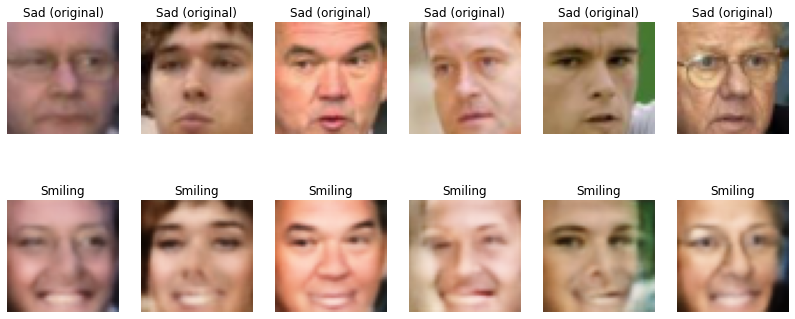

In [29]:
plt.figure(figsize=(14, 6))
for i in range(COUNT):
    plt.subplot(2, COUNT, i+1)
    plt.axis("off")
    plt.title('Sad (original)')
    plt.imshow(val_data[val_sad_indexes][i])

    plt.subplot(2, 6, i+COUNT+1)
    plt.axis("off")
    plt.title('Smiling')
    plt.imshow(tensor2image(outputs[i]))
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

## Load MNIST dataset

In [30]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
image, label = test_dataset[0]

In [32]:
label

7

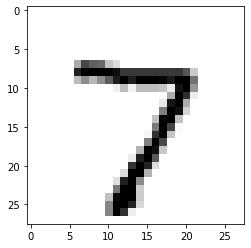

In [33]:
plt.imshow(image[0].numpy().squeeze(), cmap='gray_r')

## VAE architecture

In [34]:
vae_dim_code = 128

In [35]:
class VAE(nn.Module):
    def __init__(self, training: bool):
        super().__init__()
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        self.training = training
        
        filters = [64, 128]
        encoder_output_dim = filters[-1] * 7 * 7
        modules = []
        in_channels = 1
        # 1. Encoder
        for f in filters:
            modules.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(in_channels),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=in_channels, out_channels=f, kernel_size=3, padding=1),
                nn.BatchNorm2d(f),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)))
            in_channels = f
            
        self.encoder = nn.Sequential(*modules)
        self.enc_fc_mean = nn.Linear(encoder_output_dim, vae_dim_code)
        self.enc_fc_std = nn.Linear(encoder_output_dim, vae_dim_code)
        
        # 2. Decoder
        modules = []
        
        self.dec_fc0 = nn.Linear(vae_dim_code, encoder_output_dim)
        filters.reverse()
        for idx in range(len(filters)-1):
            f = filters[idx]
            out_channels = filters[idx+1]
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(f, f, kernel_size=2, stride=2),
                nn.Conv2d(in_channels=f, out_channels=out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU()))
        
        self.decoder = nn.Sequential(*modules)
        self.decoder_final_output = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            #nn.BatchNorm2d(32),
            nn.Sigmoid())

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве возвращаемых переменных -- mu и logsigma>
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        mu = self.enc_fc_mean(x)
        log_sqr_sigma = self.enc_fc_std(x) # I use log_sqr_sigma instead of logsigma,
        # in order to emphasize that here it is log(sigma^2)
        return mu, log_sqr_sigma
    
    def gaussian_sampler(self, mu, log_sqr_sigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5*log_sqr_sigma) # because exp(0.5*log(sigma^2)) -> sigma (it is std)
            eps = torch.randn_like(std) # get a random tensor ~ N(O, I) (standard normal distribution)
            #eps = torch.normal(mean=torch.tensor(0.0), std=torch.tensor(0.1))
            return mu + eps*std
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве ваозвращаемой переменной -- reconstruction>
        z = self.dec_fc0(z)
        z = z.view(-1, 128, 7, 7)
        z = self.decoder(z)
        reconstruction = self.decoder_final_output(z)
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве возвращаемых переменных -- mu, logsigma и reconstruction>
        mu, log_sqr_sigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, log_sqr_sigma)
        reconstruction = self.decode(latent_code)
        return mu, log_sqr_sigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [36]:
def KL_divergence(mu, log_sqr_sigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    # <напишите код для KL-дивергенции, пользуясь формулой выше>
    kl_loss = torch.sum(-0.5 * torch.sum(1 + log_sqr_sigma - torch.pow(mu, 2) - torch.exp(log_sqr_sigma),dim=1), dim=0)
    return kl_loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    #<binary cross-entropy>
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, log_sqr_sigma, reconstruction):
    kl_loss = KL_divergence(mu, log_sqr_sigma)
    ll_loss = log_likelihood(x, reconstruction)
    loss = kl_loss + ll_loss #<соедините тут две компоненты лосса. Mind the sign!>
    
    kl_loss_val = kl_loss.detach().cpu().item()
    ll_loss_val = ll_loss.detach().cpu().item()
    return loss, kl_loss_val, ll_loss_val

И обучим модель:

In [37]:
criterion = loss_vae

autoencoder = VAE(training=True).to(device)

NUM_EPOCHS = 70
lr = 8e-3
weight_decay=0.01
optimizer = optim.AdamW(autoencoder.parameters(), lr=lr, weight_decay=weight_decay)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
num_warmup_steps=int(len(train_dataset)/BATCH_SIZE*40)
scheduler = get_cosine_schedule_with_warmup(optimizer,
        num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

print(num_warmup_steps, num_train_steps)

18750 32812


In [38]:
def train_fn(net, loader, criterion, optimizer, scheduler=None):
    running_kl_loss = 0
    running_ll_loss = 0
    processed_data = 0
    
    pbar = tqdm(total = len(loader), desc='Training')
    for _, (in_images, labels) in enumerate(loader):
        in_images = in_images.to(device)
        net.train()
        optimizer.zero_grad()
        mu, log_sqr_sigma, reconstruction = net.forward(in_images)
        loss, kl_loss, ll_loss = criterion(in_images, mu, log_sqr_sigma, reconstruction)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        b, c, h, w = in_images.shape
        running_kl_loss += kl_loss / vae_dim_code
        running_ll_loss += ll_loss / (c*h*w)
        processed_data += b
        
        pbar.update()
    
    pbar.close()
    train_loss = (running_kl_loss + running_ll_loss) / processed_data
    return train_loss


def valid_fn(net, loader, criterion):
    
    running_kl_loss = 0
    running_ll_loss = 0
    processed_data = 0
    
    pbar = tqdm(total = len(loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for _, (in_images, labels) in enumerate(loader):
            
            in_images = in_images.to(device)
            net.eval()
            mu, log_sqr_sigma, reconstruction = net.forward(in_images)
            loss, kl_loss, ll_loss = criterion(in_images, mu, log_sqr_sigma, reconstruction)
            
            b, c, h, w = in_images.shape
            running_kl_loss += kl_loss / vae_dim_code
            running_ll_loss += ll_loss / (c*h*w)
            processed_data += b
            
            pbar.update()
    
    pbar.close()
    val_loss = (running_kl_loss + running_ll_loss) / processed_data
    return val_loss

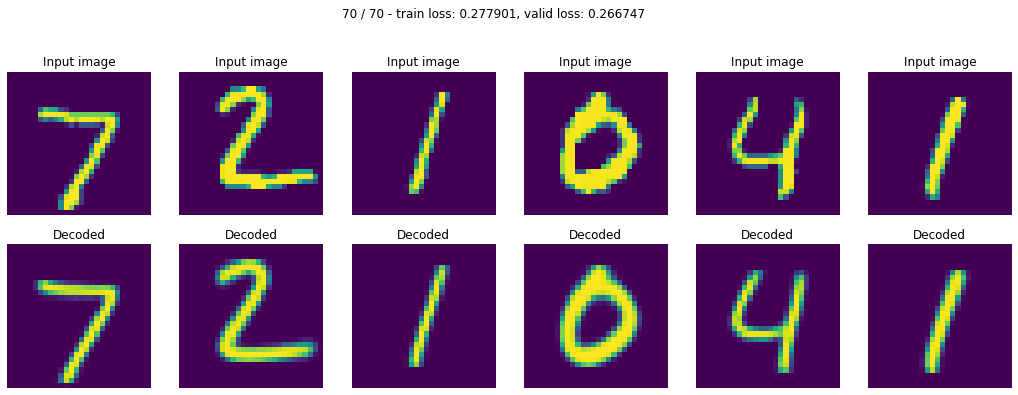

In [39]:
train_loss = []
valid_loss = []

X_val, labels = next(iter(test_loader)) # for visualizing
X_val = X_val.to(device)

for epoch in range(NUM_EPOCHS):
    
    tl = train_fn(autoencoder, train_loader, criterion, optimizer, scheduler)
    vl = valid_fn(autoencoder, test_loader, criterion)
    train_loss.append(tl)
    valid_loss.append(vl)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl)
    tqdm.write(printstr)
    
    # Visualize tools
    autoencoder.eval()
    with torch.no_grad():
        _, _, Y_hat = autoencoder(X_val)
        Y_hat = Y_hat.detach().cpu()

    clear_output(wait=True)
    plt.figure(figsize=(18,9))
    for k in range(6):
        plt.subplot(3, 6, k+1)
        plt.imshow(tensor2image(X_val[k]))
        plt.title('Input image')
        plt.axis('off')

        plt.subplot(3, 6, k+7)
        plt.imshow(tensor2image(Y_hat[k]))
        plt.title('Decoded')
        plt.axis('off')
    plt.suptitle('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, NUM_EPOCHS, tl, vl))
    plt.show()

/home/neurus/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/neurus/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


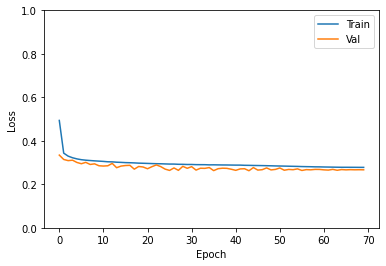

In [40]:
plt.figure()
plt.ylim(0, 1.0)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

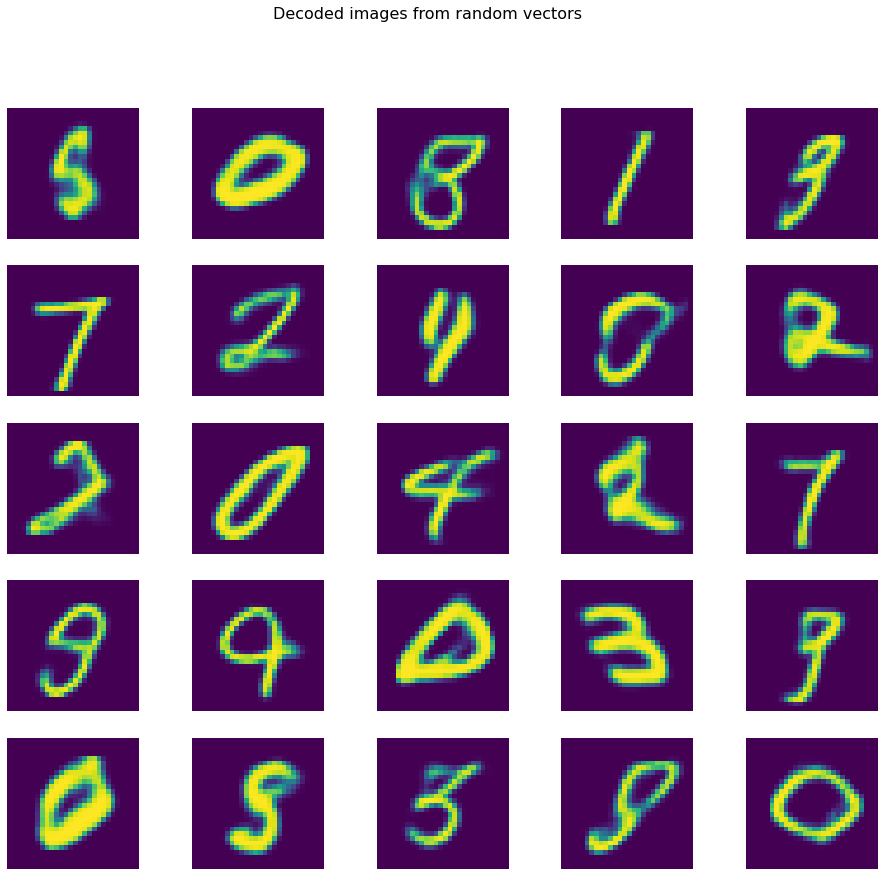

In [41]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 128) for i in range(25)])

autoencoder.eval()
with torch.no_grad():
    z = torch.tensor(z).to(device, torch.float32)
    output = autoencoder.decode(z)
    output = output.detach().cpu()

# отрисуем вывод декодера по этим векторам
fig = plt.figure(figsize=(16,14))
fig.suptitle('Decoded images from random vectors', fontsize=16)

for image_idx in range(len(output)):
    ax = fig.add_subplot(5, 5, image_idx+1)
    ax.imshow(tensor2image(output[image_idx]))
    ax.axis('off')

plt.show()

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [42]:
from sklearn.manifold import TSNE

In [43]:
mnist_test_data_latent_vectors = []
mnist_test_data_labels = []

with torch.no_grad():
    for _, (in_images, labels) in enumerate(test_loader):
        in_images = in_images.to(device)
        autoencoder.eval()
        mu, log_sqr_sigma = autoencoder.encode(in_images)
        
        # Можно autoencoder.training=False => autoencoder.gaussian_sampler(mu, log_sqr_sigma)
        # вернет mu. Но зачем делать лишнее, так что сразу берем mu
        latent_codes = mu.detach().cpu().numpy()
        
        mnist_test_data_latent_vectors.append(latent_codes)
        labels = labels.detach().cpu().numpy().tolist()
        mnist_test_data_labels.extend(labels)

mnist_test_data_latent_vectors = np.vstack(mnist_test_data_latent_vectors)
mnist_test_data_labels = np.array(mnist_test_data_labels)

In [44]:
mnist_test_data_latent_vectors_embedded = TSNE(n_components=2).fit_transform(mnist_test_data_latent_vectors)

In [45]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

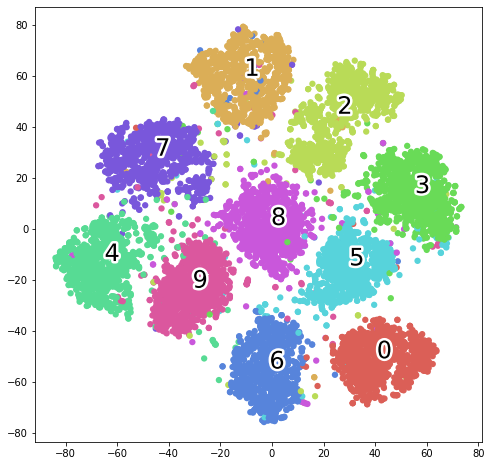

In [46]:
f, ax, sc, txts = scatter(mnist_test_data_latent_vectors_embedded, mnist_test_data_labels)
plt.show()

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [79]:
cvae_dim_code = 128
ONE_HOT_SIZE = 10

class CVAE(nn.Module):
    def __init__(self, training: bool):
        super().__init__()
        
        self.training = training
        
        filters = [64, 128]
        encoder_output_dim = filters[-1] * 7 * 7
        modules = []
        in_channels = 1
        # 1. Encoder
        for f in filters:
            modules.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(in_channels),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=in_channels, out_channels=f, kernel_size=3, padding=1),
                nn.BatchNorm2d(f),
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)))
            in_channels = f
            
        self.encoder = nn.Sequential(*modules)
        self.enc_fc_mean = nn.Linear(encoder_output_dim + ONE_HOT_SIZE, cvae_dim_code)
        self.enc_fc_std = nn.Linear(encoder_output_dim + ONE_HOT_SIZE, cvae_dim_code)
        
        # 2. Decoder
        modules = []
        
        self.dec_fc0 = nn.Linear(cvae_dim_code + ONE_HOT_SIZE, encoder_output_dim)
        filters.reverse()
        for idx in range(len(filters)-1):
            f = filters[idx]
            out_channels = filters[idx+1]
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(f, f, kernel_size=2, stride=2),
                nn.Conv2d(in_channels=f, out_channels=out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU()))
        
        self.decoder = nn.Sequential(*modules)
        self.decoder_final_output = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            #nn.BatchNorm2d(32),
            nn.Sigmoid())

    def encode(self, x, onehot):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = torch.cat((x, onehot), dim=1) # concatenate
        mu = self.enc_fc_mean(x)
        log_sqr_sigma = self.enc_fc_std(x)
        return mu, log_sqr_sigma
    
    def gaussian_sampler(self, mu, log_sqr_sigma):
        if self.training:

            std = torch.exp(0.5*log_sqr_sigma)
            eps = torch.randn_like(std)
            return mu + eps*std
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, onehot):
        #print('z shape=', z.shape)
        #print('z after cat shape=', z.shape)
        z = torch.cat((z,onehot), dim=1)
        z = self.dec_fc0(z)
        z = z.view(-1, 128, 7, 7)
        z = self.decoder(z)
        reconstruction = self.decoder_final_output(z)
        return reconstruction

    def forward(self, x, onehot_labels):
        mu, log_sqr_sigma = self.encode(x, onehot_labels)
        latent_code = self.gaussian_sampler(mu, log_sqr_sigma)
        reconstruction = self.decode(latent_code, onehot_labels)
        return mu, log_sqr_sigma, reconstruction

In [80]:
criterion = loss_vae

autoencoder = CVAE(training=True).to(device)

NUM_EPOCHS = 70
lr = 8e-3
weight_decay=0.01
optimizer = optim.AdamW(autoencoder.parameters(), lr=lr, weight_decay=weight_decay)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
num_warmup_steps=int(len(train_dataset)/BATCH_SIZE*40)
scheduler = get_cosine_schedule_with_warmup(optimizer,
        num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

print(num_warmup_steps, num_train_steps)

18750 32812


In [81]:
def labels_to_onehot(labels_tensor, one_hot_size):
    assert torch.max(labels_tensor).item() < one_hot_size
    labels_tensor = labels_tensor.unsqueeze(1)
    batch_size = labels_tensor.size(0)
    onehot = torch.zeros(batch_size, one_hot_size)
    onehot.scatter_(1, labels_tensor, 1)
    return onehot

In [82]:
def train_fn(net, loader, criterion, optimizer, scheduler=None):
    running_kl_loss = 0
    running_ll_loss = 0
    processed_data = 0
    
    pbar = tqdm(total = len(loader), desc='Training')
    for _, (in_images, labels) in enumerate(loader):
        in_images = in_images.to(device)
        labels = labels_to_onehot(labels, ONE_HOT_SIZE).to(device)
        net.train()
        optimizer.zero_grad()
        mu, log_sqr_sigma, reconstruction = net.forward(in_images, labels)
        loss, kl_loss, ll_loss = criterion(in_images, mu, log_sqr_sigma, reconstruction)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        b, c, h, w = in_images.shape
        running_kl_loss += kl_loss / vae_dim_code
        running_ll_loss += ll_loss / (c*h*w)
        processed_data += b
        
        pbar.update()
    
    pbar.close()
    train_loss = (running_kl_loss + running_ll_loss) / processed_data
    return train_loss


def valid_fn(net, loader, criterion):
    
    running_kl_loss = 0
    running_ll_loss = 0
    processed_data = 0
    
    pbar = tqdm(total = len(loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for _, (in_images, labels) in enumerate(loader):
            
            in_images = in_images.to(device)
            labels = labels_to_onehot(labels, ONE_HOT_SIZE).to(device)
            net.eval()
            mu, log_sqr_sigma, reconstruction = net.forward(in_images, labels)
            loss, kl_loss, ll_loss = criterion(in_images, mu, log_sqr_sigma, reconstruction)
            
            b, c, h, w = in_images.shape
            running_kl_loss += kl_loss / vae_dim_code
            running_ll_loss += ll_loss / (c*h*w)
            processed_data += b
            
            pbar.update()
    
    pbar.close()
    val_loss = (running_kl_loss + running_ll_loss) / processed_data
    return val_loss

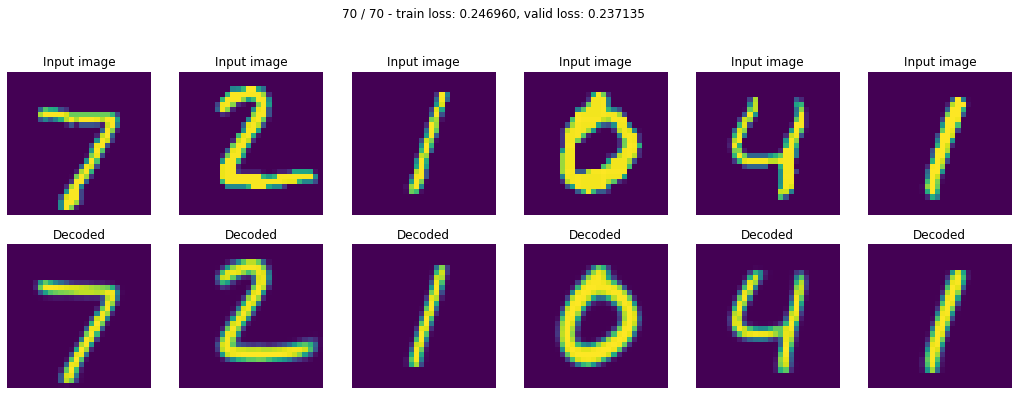

In [84]:
train_loss = []
valid_loss = []

X_val, val_example_labels = next(iter(test_loader)) # for visualizing
X_val = X_val.to(device)
val_example_labels = labels_to_onehot(val_example_labels, ONE_HOT_SIZE).to(device)

for epoch in range(NUM_EPOCHS):
    
    tl = train_fn(autoencoder, train_loader, criterion, optimizer, scheduler)
    vl = valid_fn(autoencoder, test_loader, criterion)
    train_loss.append(tl)
    valid_loss.append(vl)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl)
    tqdm.write(printstr)
    
    # Visualize tools
    autoencoder.eval()
    with torch.no_grad():
        _, _, Y_hat = autoencoder.forward(X_val, val_example_labels)
        Y_hat = Y_hat.detach().cpu()

    clear_output(wait=True)
    plt.figure(figsize=(18,9))
    for k in range(6):
        plt.subplot(3, 6, k+1)
        plt.imshow(tensor2image(X_val[k]))
        plt.title('Input image')
        plt.axis('off')

        plt.subplot(3, 6, k+7)
        plt.imshow(tensor2image(Y_hat[k]))
        plt.title('Decoded')
        plt.axis('off')
    plt.suptitle('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, NUM_EPOCHS, tl, vl))
    plt.show()

/home/neurus/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/neurus/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


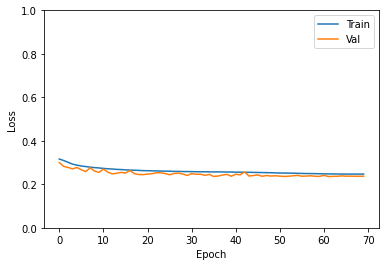

In [85]:
plt.figure()
plt.ylim(0, 1.0)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [103]:
def generate_new_digit_images(cvae, digit):
    z = np.array([np.random.normal(0, 1, 128) for i in range(5)])
    label = labels_to_onehot(torch.tensor([digit for _ in range(5)]), ONE_HOT_SIZE).to(device)

    cvae.eval()
    with torch.no_grad():
        z = torch.tensor(z).to(device, torch.float32)
        output = cvae.decode(z, label)
        output = output.detach().cpu()

    # отрисуем вывод декодера по этим векторам
    fig = plt.figure(figsize=(16,14))
    fig.suptitle('Decoded images from random vectors for digit {}'.format(digit), fontsize=16)

    for image_idx in range(len(output)):
        ax = fig.add_subplot(5, 5, image_idx+1)
        ax.imshow(tensor2image(output[image_idx]))
        ax.axis('off')
    return fig

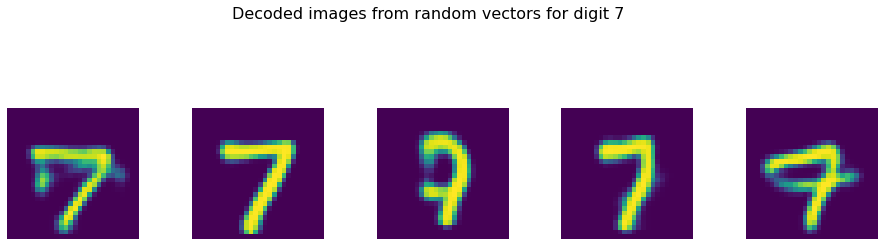

In [104]:
fig = generate_new_digit_images(autoencoder, digit=7)
plt.show()

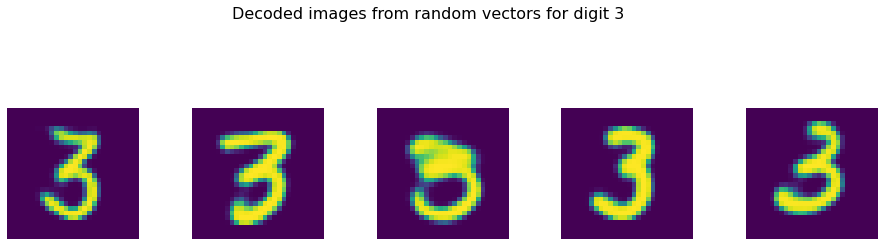

In [105]:
fig = f(autoencoder, digit=3)
plt.show()

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
<тут ваш код>

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
<тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей

    code = <получение латентного представления image>

    (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

    return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!